### Required imports

In [1]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import h5py
import pickle
import pandas
import matplotlib.pyplot as plt
import deepdish.io as io
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
tf.__version__

'1.14.0'

In [3]:
from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import RobustScaler, StandardScaler

### Loading dataset for training

In [4]:
def load_data(filename, len_input=80):
    
    f_train=h5py.File(filename,'r')
   
    x_train=f_train['table']

    x_train.shape

    x_train=x_train[:,:len_input]

    scaler=RobustScaler().fit(x_train)

    x_train=scaler.transform(x_train)
    
    f_train.close()
    return x_train

In [5]:
x_train=load_data('/data/debo/anomalyDelphes/AE_train_qcd_preprocessed.h5', 80)

### Building AutoEncoder (AE) model

In [6]:
input_dim=x_train.shape[1]

input_vec = Input(shape =(input_dim,))

encoded = Dense(256, activation='relu')(input_vec)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(6, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder=Model(input_vec, decoded)


autoencoder.compile(optimizer="adam",
                    loss="kullback_leibler_divergence") 
                    

W1108 10:33:58.337197 140275273684736 deprecation_wrapper.py:119] From /home/debo/env_autoencoder/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1108 10:33:58.372360 140275273684736 deprecation_wrapper.py:119] From /home/debo/env_autoencoder/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1108 10:33:58.380259 140275273684736 deprecation_wrapper.py:119] From /home/debo/env_autoencoder/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1108 10:33:58.535412 140275273684736 deprecation_wrapper.py:119] From /home/debo/env_autoencoder/local/lib/python2.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.comp

### Training

In [7]:

from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=8)

history=autoencoder.fit(x_train, x_train, epochs=100,
               batch_size=128,
               shuffle='batch',
               validation_split=0.2,
               callbacks=[early_stopping])

W1108 10:34:22.995436 140275273684736 deprecation.py:323] From /home/debo/env_autoencoder/local/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1108 10:34:23.064305 140275273684736 deprecation_wrapper.py:119] From /home/debo/env_autoencoder/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 480058 samples, validate on 120015 samples
Epoch 1/100
480058/480058 [==============================] - 22s 46us/step - loss: 78.7529 - val_loss: 78.2023
Epoch 2/100
480058/480058 [==============================] - 22s 46us/step - loss: 78.0313 - val_loss: 77.8679
Epoch 3/100
480058/480058 [==============================] - 23s 47us/step - loss: 77.7703 - val_loss: 77.6741
Epoch 4/100
480058/480058 [==============================] - 23s 47us/step - loss: 77.6110 - val_loss: 77.5908
Epoch 5/100
480058/480058 [==============================] - 23s 47us/step - loss: 77.5064 - val_loss: 77.4763
Epoch 6/100
480058/480058 [==============================] - 23s 48us/step - loss: 77.4356 - val_loss: 77.4206
Epoch 7/100
480058/480058 [==============================] - 23s 47us/step - loss: 77.4150 - val_loss: 77.4055
Epoch 8/100
480058/480058 [==============================] - 23s 47us/step - loss: 77.3401 - val_loss: 77.3370
Epoch 9/100
480058/480058 [==============================] -

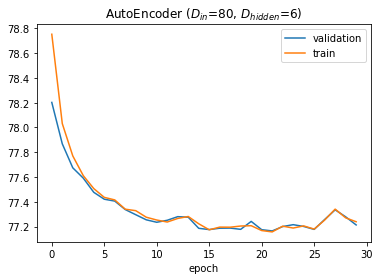

In [9]:
plt.plot(history.history['val_loss'], label='validation')
plt.plot(history.history['loss'], label='train')
plt.title('AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [11]:
autoencoder.save('/data/debo/anomalyDelphes/AE-model-d80.h5')

### Some more imports

In [12]:
from keras.models import load_model
from sklearn.metrics import mutual_info_score
from sklearn.utils import check_random_state
from sklearn.preprocessing import StandardScaler, RobustScaler

from keras.losses import kullback_leibler_divergence, mean_squared_error, cosine

### Load training data and obtain the scaler fit

In [13]:
f_train=h5py.File('/data/debo/anomalyDelphes/AE_train_qcd_preprocessed.h5','r')
x_train=f_train['table']
len_input = 80
scaler=RobustScaler().fit(x_train[:10000, :len_input])
f_train.close()

### Load preprocessed test data

In [14]:
f_test_0=h5py.File('/data/debo/anomalyDelphes/AE_test_qcd_preprocessed.h5','r')
f_test_1=h5py.File('/data/debo/anomalyDelphes/AE_test_top_preprocessed.h5','r')
x_test_0=f_test_0['table']
x_test_1=f_test_1['table']

x_test=np.concatenate((x_test_0, x_test_1), axis=0)
y_test=np.concatenate((np.zeros(len(x_test_0)), np.ones(len(x_test_1))), axis=0)

rng = check_random_state(1)
indices = rng.permutation(len(x_test))

x_test_mix = [x_test[j] for j in indices[:100000]]
y_test_mix = [y_test[j] for j in indices[:100000]]
f_test_0.close()
f_test_1.close()

In [15]:
x_test_mix=np.array(x_test_mix)
y_test_mix=np.array(y_test_mix)

### Load the model

In [18]:
autoencoder=load_model('/data/debo/anomalyDelphes/AE-model-d80.h5')

In [19]:
x_test_mix=scaler.transform(x_test_mix[:,:len_input])

### Predict output and calculate mse_loss

In [20]:
predict_jets=autoencoder.predict(x_test_mix)

In [21]:
predict_loss_mse= np.mean(np.power(x_test_mix - predict_jets, 2), axis=1)

In [22]:
predict_loss=predict_loss_mse

### Add scaling for predict_loss, not mandatory

In [23]:
tf_loss=StandardScaler().fit(predict_loss.reshape(-1,1))
predict_loss=tf_loss.transform(predict_loss.reshape(-1,1))

(array([8.9750e+03, 1.6723e+04, 7.6350e+03, 4.2540e+03, 3.3880e+03,
        3.4280e+03, 4.0540e+03, 4.9590e+03, 5.8430e+03, 6.2410e+03,
        6.1870e+03, 5.8010e+03, 4.8710e+03, 4.1140e+03, 3.3860e+03,
        2.4810e+03, 1.9350e+03, 1.4700e+03, 1.0700e+03, 7.4900e+02,
        6.0900e+02, 4.2300e+02, 3.3300e+02, 2.3000e+02, 1.8800e+02,
        1.2900e+02, 1.1300e+02, 8.2000e+01, 5.8000e+01, 6.2000e+01,
        4.8000e+01, 2.6000e+01, 3.3000e+01, 2.3000e+01, 1.4000e+01,
        1.8000e+01, 1.7000e+01, 8.0000e+00, 2.0000e+00, 2.0000e+00,
        5.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 4.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-1.30785883, -1.13496982, -0.96208081, -0.7891918 , -0.61630279,
        -0.44341378, -0.27052477, -0.09763576,  0.07525325,  0.24814226,
         0.42103127,  0.59392028,  0.76680929,  0.9396983 ,  1.11258731,
         1.28547632,  1.45836533,  1.63125434,  1.80414335,  1.97703236,
         2.14992137,  2.32

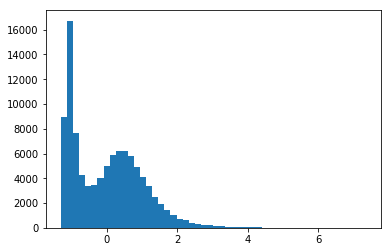

In [24]:
plt.hist(predict_loss, bins=50)

### Using mse_losses to separate QCD and Tops

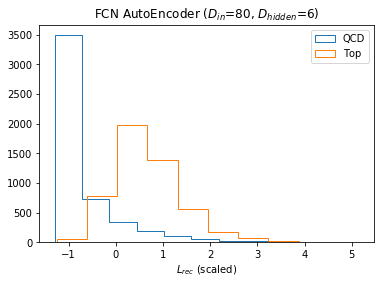

In [25]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if y_test_mix[i]==0:
        l_rec_0.append(predict_loss[i])
    else:
        l_rec_1.append(predict_loss[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='QCD')
plt.hist(l_rec_1, histtype='step', label='Top')
plt.legend(loc='best')
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('$L_{rec}$ (scaled)')
plt.show()

/home/debo/env_autoencoder/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
W1108 11:06:59.912214 140275273684736 legend.py:1383] No handles with labels found to put in legend.


('roc_auc =', 0.9202455680935037)


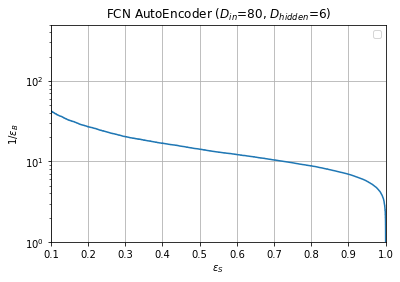

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(y_test_mix, predict_loss)
print("roc_auc =", roc_auc_score(y_test_mix, predict_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

In [49]:
print "roc_auc =", auc(fpr, tpr)

roc_auc = 0.9908453656406427
